# Import cleaned data

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy import stats

In [2]:
FOLDER = 'data/'
data = pd.read_csv(FOLDER+'data.csv', low_memory=False)
data.head(10)

,date,county_name,state,subject_race,officer_race,search_conducted,contraband_found
0,2009-10-27,Walla Walla County,WA,white,white,False,NaN
1,2009-10-04,King County,WA,black,white,False,NaN
2,2009-10-04,Kittitas County,WA,white,white,False,NaN
3,2009-10-04,Clark County,WA,white,white,False,NaN
4,2009-10-11,Kitsap County,WA,white,white,False,NaN
5,2009-10-05,Skagit County,WA,white,white,False,NaN
6,2009-10-02,Pierce County,WA,black,white,False,NaN
7,2009-10-12,King County,WA,white,black,True,False
8,2009-10-04,Grays Harbor County,WA,white,white,False,NaN
9,2009-10-27,NaN,WA,white,white,False,NaN


# 1. Stop proportions based on race

## 1.1 Data processing

Only keep the data needed for this part:

In [7]:
data_prop = data[['subject_race', 'officer_race']]
data_prop = data_prop.dropna()

data_prop.head(10)

,subject_race,officer_race
0,white,white
1,black,white
2,white,white
3,white,white
4,white,white
5,white,white
6,black,white
7,white,black
8,white,white
9,white,white


### a) Number of stops by officer race

In [8]:
# Count stops for each race in races.
# df: input dataframe; stats: output dataframe
# officer: officer race; races: list of subject races
def countStops(df, stats, officer, races):
    same_race = df[(df['officer_race'] == officer) & (df['subject_race'] == officer)]
    opposite_race = df[(df['officer_race'] == officer) & (df['subject_race'] != officer)]
    count_same = same_race.shape[0]
    count_opposite = opposite_race.shape[0]
    
    temp = pd.DataFrame([[officer, officer, count_same],[officer, 'opposite', count_opposite],
                         [officer, 'all', df[df['officer_race'] == officer].shape[0]]], columns=stats.columns)
    stats = pd.concat([stats, temp], axis=0, ignore_index=True)
    
    for race in races:
        if race!=officer:
            count = opposite_race[opposite_race['subject_race'] == race].shape[0]
            temp = pd.DataFrame([[officer, race, count]], columns=stats.columns)
            stats = pd.concat([stats, temp], axis=0, ignore_index=True)
    
    return stats

In [9]:
races = ['white', 'black', 'hispanic']
total = data_prop.shape[0]

stat = pd.DataFrame([['all', 'all', total]], columns=['officer_race', 'subject_race', 'stop_count'])

for race in races:
    count = data_prop[data_prop['subject_race'] == race].shape[0]
    temp = pd.DataFrame([['all', race, count]], columns=stat.columns)
    stat = pd.concat([stat, temp], axis=0, ignore_index=True)
    stat = countStops(data_prop, stat, race, races)

In [10]:
# Save stat
stat.to_csv(r'data/stop_count.csv', index=False)
stat.head(10)

,officer_race,subject_race,stop_count
0,all,all,18843347
1,all,white,12613455
2,white,white,11232935
3,white,opposite,4940592
4,white,all,16173527
5,white,black,3471998
6,white,hispanic,1468594
7,all,black,4221364
8,black,black,570292
9,black,opposite,1141978


### b) Proportion of stops by officer race

In [11]:
races.append('all')

In [12]:
totals = stat[stat['officer_race'].isin(races) & (stat['subject_race']=='all')]
stat['proportions'] = stat['stop_count']

for race in races:
    tot = totals[totals['officer_race'] == race].stop_count.to_numpy()[0]
    stat.loc[stat['officer_race'] == race, 'proportions'] = stat.loc[stat['officer_race'] == race, 'proportions'] / tot
    
races.remove('all')

In [13]:
stat.head(10)

,officer_race,subject_race,stop_count,proportions
0,all,all,18843347,1.000000
1,all,white,12613455,0.669385
2,white,white,11232935,0.694526
3,white,opposite,4940592,0.305474
4,white,all,16173527,1.000000
5,white,black,3471998,0.214672
6,white,hispanic,1468594,0.090802
7,all,black,4221364,0.224024
8,black,black,570292,0.333062
9,black,opposite,1141978,0.666938


## 1.2 Data visualization

### a) Number of stops by officer race

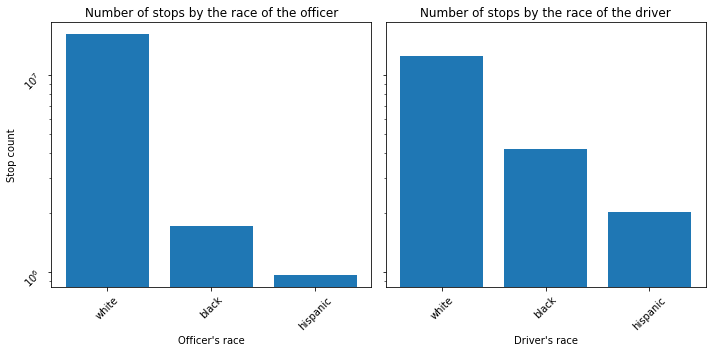

In [14]:
stat = stat.sort_values(by=['stop_count'], ignore_index=True, ascending=False)
# Plot number of stops performed by each officer race
df = stat.query("officer_race!='all' and subject_race=='all'")
# Plot number of stops on each subject_race
df2 = stat.query("officer_race=='all' and subject_race!='all'")

fig, axes = plt.subplots(1,2, figsize=(10,5), sharey=True)

axes[0].bar(df['officer_race'], df['stop_count'], log=True)
axes[1].bar(df2['subject_race'], df2['stop_count'], log=True)

# Format
axes[0].set_ylabel('Stop count')
axes[0].set_xlabel("Officer's race")
axes[0].set_title('Number of stops by the race of the officer')
axes[0].tick_params(labelrotation=45)

axes[1].set_xlabel("Driver's race")
axes[1].set_title('Number of stops by the race of the driver')
axes[1].tick_params(labelrotation=45)

fig.tight_layout()

### b) Proportion of stops by officer race

In [15]:
stat.head(50)

,officer_race,subject_race,stop_count,proportions
0,all,all,18843347,1.000000
1,white,all,16173527,1.000000
2,all,white,12613455,0.669385
3,white,white,11232935,0.694526
4,white,opposite,4940592,0.305474
5,all,black,4221364,0.224024
6,white,black,3471998,0.214672
7,all,hispanic,2008528,0.106591
8,black,all,1712270,1.000000
9,white,hispanic,1468594,0.090802


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


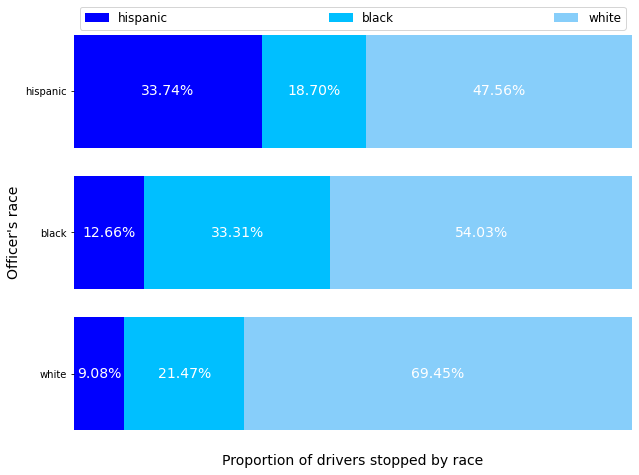

In [16]:
# Initialize the matplotlib figure
f, ax = plt.subplots(figsize=(10, 8))

# Params for the plot aspect
colors = ["lightskyblue", 'deepskyblue', 'blue']

# Compute the left offset for each race
for race in races:
    left = 1
    for race2 in races:
        left = left - stat.loc[(stat['officer_race']==race) & (stat['subject_race']==race2), 'proportions'].to_numpy()[0]
        stat.loc[(stat['officer_race']==race) & (stat['subject_race']==race2), 'left'] = left

# Plot the barplot
for i in range(len(races)):
    df = stat[(stat['officer_race']!='all') & (stat['subject_race']==races[i])]
    ax.barh(df["officer_race"], df["proportions"], left=df["left"], label=races[i], color=colors[i])
    
    # Add values to the figure
    for row in df.iterrows(): 
        value = row[1]["proportions"]
        xcenter = row[1]["left"] + value/2
        ax.text(xcenter, row[1]['officer_race'], "{:.2f}".format(value* 100)+"%", ha='center', va='center', color="white", fontsize=14)
        
# Add a legend and informative axis label
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles[::-1], labels[::-1], mode="expand", frameon=True, loc='upper center', ncol=3, bbox_to_anchor=(0., 0.93, 1., .102),fontsize=12)
ax.set(xlim=(0, 1), xticks=[])
ax.set_xlabel(xlabel="Proportion of drivers stopped by race",fontsize=14)
ax.set_ylabel(ylabel="Officer's race",fontsize=14)
sns.despine(left=True, bottom=True)
f.savefig("figs/stopped_proportions", format="eps")

# 2. Search rates based on race

## 2.1 Data processing

Only keep the data we need for this part:

In [17]:
data_search =  data[['county_name', 'state', 'officer_race', 'subject_race', 'search_conducted']]
data_search = data_search.dropna()

In [18]:
data_search.head(10)

,county_name,state,officer_race,subject_race,search_conducted
0,Walla Walla County,WA,white,white,False
1,King County,WA,white,black,False
2,Kittitas County,WA,white,white,False
3,Clark County,WA,white,white,False
4,Kitsap County,WA,white,white,False
5,Skagit County,WA,white,white,False
6,Pierce County,WA,white,black,False
7,King County,WA,black,white,True
8,Grays Harbor County,WA,white,white,False
10,Skagit County,WA,white,white,False


### a) Compute search rates by county for each subject race

In [19]:
# Compute rate (either hit rate or search rate) of given variable
def computeRate(data, races, variable, column_names):
    rates = pd.DataFrame(columns=column_names)
    group = data.groupby(['county_name', 'state', 'officer_race'])
    
    for idx, df in group:
        for race in races:
            if variable == 'contraband_found':
                total = df[(df['search_conducted']==True) & (df['subject_race']==race)].shape[0]
            else :
                total = df[df['subject_race']==race].shape[0]
            positive = df.loc[(df[variable]==True) & (df['subject_race']==race)].shape[0]
            if total != 0:
                temp = pd.DataFrame([[idx[0], idx[1], idx[2], race, (positive/total), positive, total]], columns=rates.columns)
                rates = pd.concat([rates, temp], axis=0, ignore_index=True)
        
    return rates

In [20]:
column_names=['county_name', 'state', 'officer_race', 'subject_race', 'search_rate', 'count_searched', 'total_stops']
rates = computeRate(data_search, races, 'search_conducted', column_names)
# Save data
rates.to_csv(r'data/search_rates.csv', index=False)
rates.head(10)

,county_name,state,officer_race,subject_race,search_rate,count_searched,total_stops
0,Abbeville County,SC,black,white,0.005071,5,986
1,Abbeville County,SC,black,black,0.012788,5,391
2,Abbeville County,SC,black,hispanic,0.028571,2,70
3,Abbeville County,SC,hispanic,white,0.000000,0,2
4,Abbeville County,SC,white,white,0.017481,428,24484
5,Abbeville County,SC,white,black,0.026672,365,13685
6,Abbeville County,SC,white,hispanic,0.074545,41,550
7,Adams County,WA,black,white,0.000000,0,1
8,Adams County,WA,hispanic,white,0.004762,11,2310
9,Adams County,WA,hispanic,black,0.022989,2,87


### b) Compute search rates for subjects of same & different race than that of the officer

In [21]:
# Compute rate for variable for subject of same/different race than officer's race
def computeRateRace(data, variable, column_names):
    stats_race = pd.DataFrame(columns=column_names)
    group = data.groupby(['county_name', 'state', 'officer_race'])

    for idx, df in group:
        data_same = df.loc[df['subject_race']==idx[2]]
        rate_same = data_same[variable].to_numpy(dtype=np.float64)
        
        if rate_same.size > 0: # Some counties don't have data for some races
            data_diff = df.loc[df['subject_race']!=idx[2]]
            diff = data_diff[data.columns.tolist()[-2]].sum() # Sum of count_seached or count_contraband
            diff_tot = data_diff[data.columns.tolist()[-1]].sum() # Sum of total_stops or total_searches
            
            rate_diff = np.nan
            if diff_tot != 0: # Avoid division by 0
                rate_diff = diff / diff_tot
            temp = pd.DataFrame([[idx[0], idx[1], idx[2], True, rate_same[0],
                                  data_same[data.columns.tolist()[-2]].sum(), data_same[data.columns.tolist()[-1]].sum()],
                            [idx[0], idx[1], idx[2], False, rate_diff, diff, diff_tot]], columns=stats_race.columns)
            stats_race = pd.concat([stats_race, temp], axis=0, ignore_index=True)
        
    return stats_race

In [22]:
column_names = ['county_name', 'state', 'officer_race', 'same_race_officer', 'search_rate', 'count_searched', 'total_stops']
stats_search = computeRateRace(rates,'search_rate', column_names)
stats_search.head(10)

,county_name,state,officer_race,same_race_officer,search_rate,count_searched,total_stops
0,Abbeville County,SC,black,True,0.012788,5,391
1,Abbeville County,SC,black,False,0.006629,7,1056
2,Abbeville County,SC,white,True,0.017481,428,24484
3,Abbeville County,SC,white,False,0.028521,406,14235
4,Adams County,WA,hispanic,True,0.012397,3,242
5,Adams County,WA,hispanic,False,0.005423,13,2397
6,Adams County,WA,white,True,0.015184,994,65463
7,Adams County,WA,white,False,0.032245,387,12002
8,Aiken County,SC,black,True,0.030739,318,10345
9,Aiken County,SC,black,False,0.025676,491,19123


### c) Data visualization

In [23]:
# Plots the scatter plot
# Factor is used to scale the area
def plotScatter(ax, df, variable, race, factor):
    mask= "officer_race=='"+race+"'"
    same = df.query(mask+" and same_race_officer==True")
    diff = df.query(mask+" and same_race_officer==False")
    area = same[df.columns.tolist()[-2]].to_numpy(dtype=np.float64) + diff[df.columns.tolist()[-2]].to_numpy(dtype=np.float64)
    ax.scatter(same[variable] * 100, diff[variable] * 100, marker='o', color='None', alpha=1, edgecolor='k', linewidth=0.5, s=area * factor)
    
    # Add the line y=x
    lim = df.query(mask)[variable].max() * 100
    x = np.linspace(0,lim)
    ax.plot(x, x, ls='--', color='k', alpha=0.7)
    ax.set_xlabel(race+' officer and '+race+' driver')
    ax.set_ylabel(race+' officer and non '+race+' driver')

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


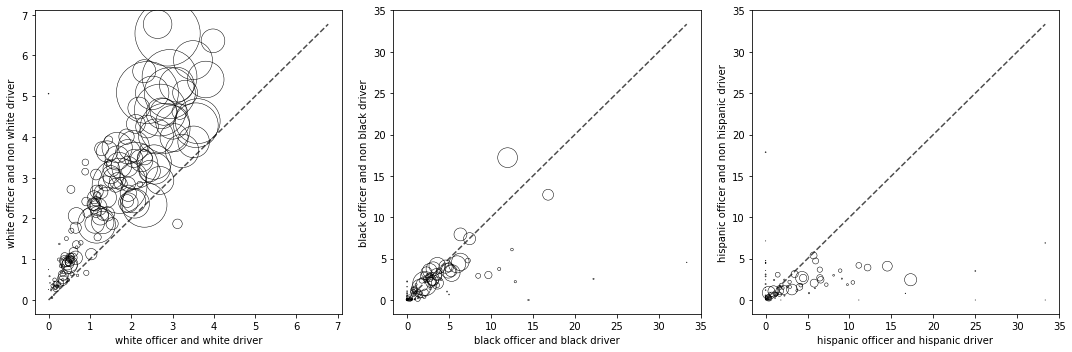

In [24]:
fig, axes = plt.subplots(1, 3, figsize=(15,5))

for i in range(len(races)):    
    plotScatter(axes[i], stats_search, 'search_rate', races[i], 0.2)
    
fig.tight_layout()
fig.savefig("figs/scatter_search", format="eps")

### d) Confidence intervals

In [25]:
# Input: your array and the number of random samples (e.g., 1000 is a good number)
# Output: [lower error, upper error]

def bootstrap_CI(data, nbr_draws):
    means = np.zeros(nbr_draws)
    data = np.array(data)

    for n in range(nbr_draws):
        indices = np.random.randint(0, len(data), len(data))
        data_tmp = data[indices] 
        means[n] = np.nanmean(data_tmp)

    return [np.nanpercentile(means, 2.5),np.nanpercentile(means, 97.5)]

In [26]:
def computeCI(data, variable):
    ci = pd.DataFrame(columns=['officer_race', 'same_race_officer', 'lower_error', 'mean', 'upper_error'])

    for race in races:
        temp_same = data[(data['officer_race']==race) & data['same_race_officer']==True][variable]
        ci_temp_same = bootstrap_CI(temp_same, 1000)
        temp_diff = data[(data['officer_race']==race) & data['same_race_officer']==False][variable]
        ci_temp_diff = bootstrap_CI(temp_diff, 1000)
        temp = pd.DataFrame([[race, True, ci_temp_same[0], temp_same.mean(), ci_temp_same[1]],
                            [race, False, ci_temp_diff[0], temp_diff.mean(), ci_temp_diff[1]]], columns=ci.columns)
        ci = pd.concat([ci, temp], ignore_index=True)
    return ci

In [27]:
ci_search = computeCI(stats_search, 'search_rate')
ci_search.head(10)

,officer_race,same_race_officer,lower_error,mean,upper_error
0,white,True,0.011731,0.013445,0.014961
1,white,False,0.019138,0.021843,0.024665
2,black,True,0.017062,0.024084,0.033176
3,black,False,0.017348,0.019489,0.021833
4,hispanic,True,0.020952,0.031350,0.042972
5,hispanic,False,0.016540,0.018327,0.020298


# 3. Hit rates based on race

Only keep the data we need for this part:

In [28]:
data_hit = data[['county_name', 'state', 'officer_race', 'subject_race', 'search_conducted', 'contraband_found']]
data_hit = data_hit.dropna()

### a) Compute hit rates by county for each subject race

In [29]:
column_names=['county_name', 'state', 'officer_race', 'subject_race', 'hit_rate', 'count_contraband', 'total_searches']
hit = computeRate(data_hit, races, 'contraband_found', column_names)

# Save data
hit.to_csv(r'data/hit_rates.csv', index=False)
hit.head(10)

,county_name,state,officer_race,subject_race,hit_rate,count_contraband,total_searches
0,Abbeville County,SC,black,white,0.200000,1,5
1,Abbeville County,SC,black,black,0.800000,4,5
2,Abbeville County,SC,black,hispanic,0.000000,0,2
3,Abbeville County,SC,white,white,0.413551,177,428
4,Abbeville County,SC,white,black,0.405479,148,365
5,Abbeville County,SC,white,hispanic,0.097561,4,41
6,Adams County,WA,hispanic,white,0.090909,1,11
7,Adams County,WA,hispanic,black,0.500000,1,2
8,Adams County,WA,hispanic,hispanic,0.000000,0,3
9,Adams County,WA,white,white,0.352113,350,994


### b) Compute hit rates for subjects of same & different race than that of the officer

In [30]:
column_names = ['county_name', 'state', 'officer_race', 'same_race_officer', 'hit_rate', 'count_contraband', 'total_searches']
stats_hit = computeRateRace(hit,'hit_rate', column_names)
stats_hit.head(10)

,county_name,state,officer_race,same_race_officer,hit_rate,count_contraband,total_searches
0,Abbeville County,SC,black,True,0.800000,4,5
1,Abbeville County,SC,black,False,0.142857,1,7
2,Abbeville County,SC,white,True,0.413551,177,428
3,Abbeville County,SC,white,False,0.374384,152,406
4,Adams County,WA,hispanic,True,0.000000,0,3
5,Adams County,WA,hispanic,False,0.153846,2,13
6,Adams County,WA,white,True,0.352113,350,994
7,Adams County,WA,white,False,0.222222,86,387
8,Aiken County,SC,black,True,0.113208,36,318
9,Aiken County,SC,black,False,0.087576,43,491


### c) Data visualization

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


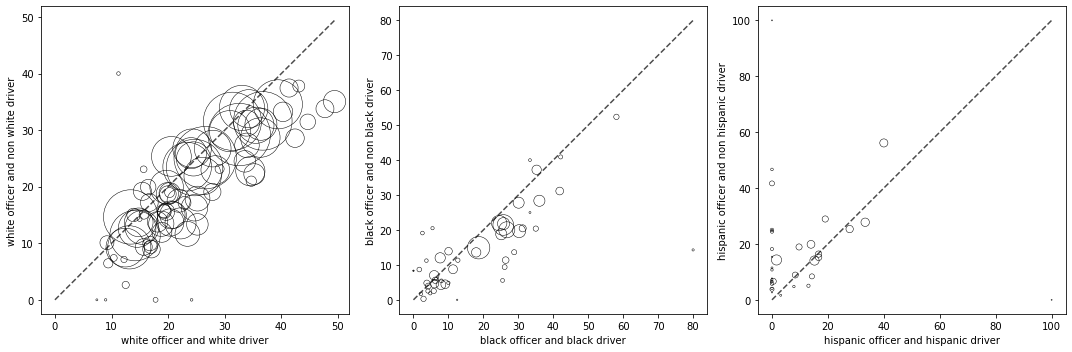

In [31]:
fig, axes = plt.subplots(1, 3, figsize=(15,5))

for i in range(len(races)):    
    plotScatter(axes[i], stats_hit, 'hit_rate',races[i], 1)
    
fig.tight_layout()
fig.savefig("figs/scatter_hit", format="eps")

### d) Confidence intervals

In [32]:
ci_hit = computeCI(stats_hit, 'hit_rate')
ci_hit.head(10)

,officer_race,same_race_officer,lower_error,mean,upper_error
0,white,True,0.218296,0.238753,0.258712
1,white,False,0.143680,0.161297,0.179897
2,black,True,0.138504,0.182564,0.229580
3,black,False,0.164717,0.179624,0.195144
4,hispanic,True,0.039864,0.085263,0.150625
5,hispanic,False,0.178038,0.192397,0.207460


### c) Student t-test

In [33]:
def ttest(data, races):
    df = pd.DataFrame(columns=['officer_race', 'mean_same_race', 'mean_diff_race', 't-statistic', 'p-value'])
    for race in races:
        same_race = data[(data['officer_race']==race) & (data['same_race_officer']==True)]['hit_rate']
        diff_race = data[(data['officer_race']==race) & (data['same_race_officer']==False)]['hit_rate']
        result = stats.ttest_ind(same_race, diff_race)
        temp = pd.DataFrame([[race, same_race.mean(), diff_race.mean(), result[0], result[1]]], columns=df.columns)
        df = pd.concat([df, temp], ignore_index=True)
    return df

In [34]:
stats_hit = stats_hit.dropna()
ttest_hit = ttest(stats_hit, races)
ttest_hit.head(10)

,officer_race,mean_same_race,mean_diff_race,t-statistic,p-value
0,white,0.238753,0.195362,2.883348,0.004456
1,black,0.182564,0.142436,1.394948,0.166185
2,hispanic,0.085263,0.162827,-1.863951,0.066140


# 4. Search rate and hit rate based on officer race only

## a) Compute rates

In [35]:
def computeRaceOfficer(data, column_names):
    stats_officer = pd.DataFrame(columns=column_names)
    group = data.groupby(['county_name', 'state', 'officer_race'])
    
    for idx, df in group:
        
        count = df.iloc[:, -2].sum() # Sum of count_searches / count_contraband
        total = df.iloc[:, -1].sum() # Sum of total_stops / total_searches
            
        if total != 0: # Avoid division by 0
            rate = count/total
            temp = pd.DataFrame([[idx[0], idx[1], idx[2], rate, count, total]], columns=column_names)
            stats_officer = pd.concat([stats_officer, temp], axis=0, ignore_index=True)
            
    return stats_officer

In [36]:
# Search rate
column_names = ['county_name', 'state', 'officer_race', 'search_rate', 'count_searches', 'total_stops']
search_officer = computeRaceOfficer(rates, column_names)

search_officer.head(10)

,county_name,state,officer_race,search_rate,count_searches,total_stops
0,Abbeville County,SC,black,0.008293,12,1447
1,Abbeville County,SC,hispanic,0.000000,0,2
2,Abbeville County,SC,white,0.021540,834,38719
3,Adams County,WA,black,0.000000,0,1
4,Adams County,WA,hispanic,0.006063,16,2639
5,Adams County,WA,white,0.017827,1381,77465
6,Aiken County,SC,black,0.027454,809,29468
7,Aiken County,SC,hispanic,0.038438,63,1639
8,Aiken County,SC,white,0.038581,9954,258002
9,Alachua County,FL,black,0.000917,5,5451


In [37]:
# Hit rate
column_names = ['county_name', 'state', 'officer_race', 'hit_rate', 'count_contraband', 'total_searches']
hit_officer = computeRaceOfficer(hit, column_names)

hit_officer.head(10)

,county_name,state,officer_race,hit_rate,count_contraband,total_searches
0,Abbeville County,SC,black,0.416667,5,12
1,Abbeville County,SC,white,0.394484,329,834
2,Adams County,WA,hispanic,0.125000,2,16
3,Adams County,WA,white,0.315713,436,1381
4,Aiken County,SC,black,0.097651,79,809
5,Aiken County,SC,hispanic,0.158730,10,63
6,Aiken County,SC,white,0.344284,3427,9954
7,Allendale County,SC,black,0.014910,29,1945
8,Allendale County,SC,white,0.387097,144,372
9,Anderson County,SC,black,0.228043,148,649


## b) Visualization

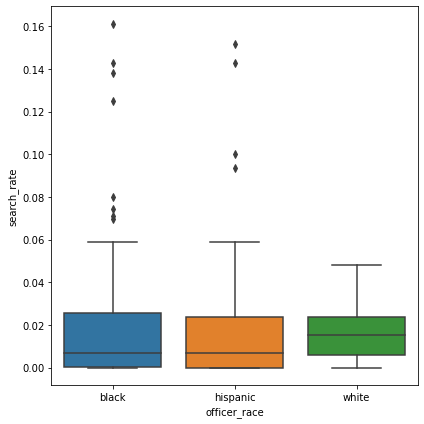

In [38]:
# Search rate
# Initialize the matplotlib figure
f, ax = plt.subplots(figsize=(6, 6))

sns.boxplot(x="officer_race", y="search_rate",data=search_officer)
#sns.despine(offset=10, trim=True)
f.tight_layout()

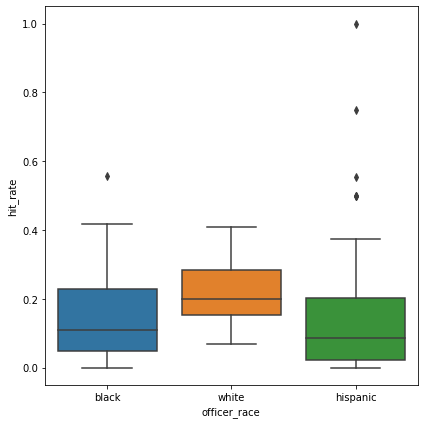

In [39]:
# Hit rate
# Initialize the matplotlib figure
f, ax = plt.subplots(figsize=(6, 6))

sns.boxplot(x="officer_race", y="hit_rate",data=hit_officer)
#sns.despine(offset=10, trim=True)
f.tight_layout()
f.savefig("figs/boxplot_hit", format="eps")